CZYTANIE PLIKÓW

In [1]:
import zipfile
import os

zip_path = "Samsung_HAR.zip" 

extract_to = "extracted_data"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [2]:
import pandas as pd

In [3]:
target_folder = os.path.join(extract_to, "samsung_HAR")
text_files = []
if os.path.exists(target_folder):
    for file in os.listdir(target_folder):
        file_path = os.path.join(target_folder, file)
        if file.endswith('.txt') and os.path.isfile(file_path):  
            text_files.append(file_path)

In [4]:
import chardet

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
        return result['encoding']

dfs = []
for file in text_files:
    encoding = detect_encoding(file)
    print(f"Detected encoding for {file}: {encoding}")
    
    try:
        df = pd.read_csv(file, encoding=encoding, delim_whitespace=True, header=None) 
        dfs.append(df)
    except Exception as e:
        print(f"Failed to read {file}: {e}")


Detected encoding for extracted_data\samsung_HAR\samsung_test.txt: ascii


C:\Users\user\AppData\Local\Temp\ipykernel_10616\1640537430.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, encoding=encoding, delim_whitespace=True, header=None)


Detected encoding for extracted_data\samsung_HAR\samsung_test_labels.txt: ascii


C:\Users\user\AppData\Local\Temp\ipykernel_10616\1640537430.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, encoding=encoding, delim_whitespace=True, header=None)


Detected encoding for extracted_data\samsung_HAR\samsung_train.txt: ascii


C:\Users\user\AppData\Local\Temp\ipykernel_10616\1640537430.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, encoding=encoding, delim_whitespace=True, header=None)


Detected encoding for extracted_data\samsung_HAR\samsung_train_labels.txt: ascii


C:\Users\user\AppData\Local\Temp\ipykernel_10616\1640537430.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, encoding=encoding, delim_whitespace=True, header=None)


In [5]:
for df in dfs:
    print(df.shape)

(2947, 561)
(2947, 1)
(7352, 561)
(7352, 1)


OBRÓBKA DANYCH

Obróbkę danych zaczniemy od połączenia danych treningowych i testowych, jakoże używamy metod unsupervised learningu, a więc ten podział jest nam niepotrzebny.

In [6]:
X = pd.concat([dfs[0], dfs[2]], axis=0, ignore_index=True)
y = pd.concat([dfs[1], dfs[3]], axis=0, ignore_index=True)
print(X.shape,y.shape)

(10299, 561) (10299, 1)


Następnie sprawdzimy, czy występują brakujące wartości i poddamy dane standaryzacji.

In [7]:
X.isnull().sum().sum()

np.int64(0)

In [8]:
y.isnull().sum().sum()

np.int64(0)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

Pobrałam nazwy wszystkich cech dla danych wejściowych ze strony: https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

In [10]:
features = pd.read_csv("features.txt", header=None, delim_whitespace=True)
feature_names = features[1].values
X.columns = feature_names
print(X.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.257178          -0.023285          -0.014654         -0.938404   
1           0.286027          -0.013163          -0.119083         -0.975415   
2           0.275485          -0.026050          -0.118152         -0.993819   
3           0.270298          -0.032614          -0.117520         -0.994743   
4           0.274833          -0.027848          -0.129527         -0.993852   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.920091         -0.667683         -0.952501         -0.925249   
1         -0.967458         -0.944958         -0.986799         -0.968401   
2         -0.969926         -0.962748         -0.994403         -0.970735   
3         -0.973268         -0.967091         -0.995274         -0.974471   
4         -0.967445         -0.978295         -0.994111         -0.965953   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

C:\Users\user\AppData\Local\Temp\ipykernel_10616\4035701341.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv("features.txt", header=None, delim_whitespace=True)


Dla danych wejściowych mamy aż 561 cech. Z pewnością tę liczbę da się zredukować używając PCA. Wybiorę tyle cech, abyśmy mieli 95% explained variance.

In [11]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_standardized)

cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(n_components)

pca = PCA(random_state=42,n_components=n_components)
X_pca = pca.fit_transform(X_standardized)
X_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
X_pca.head()

104


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104
0,-10.405412,-1.663856,2.105716,-1.118992,-3.764801,0.108509,-2.693734,-3.189612,-2.021373,1.733798,...,-0.894113,-0.219211,-0.129561,0.003174,-0.278882,-0.371835,0.009049,0.440753,1.004972,1.549244
1,-13.321701,-0.984281,-0.253654,-2.919256,-3.090713,1.895982,1.073696,0.121955,0.624020,2.332402,...,0.554748,0.639884,0.154850,-1.528793,-0.079640,0.489951,0.693112,-0.409618,-0.222273,-0.010206
2,-14.517658,2.450289,-1.451648,-2.757718,-2.129888,-0.672498,-0.873500,-2.141262,-2.703607,-2.455711,...,0.752465,0.834657,-0.071189,1.235775,0.296989,0.257269,-0.981789,0.042495,-0.698652,-0.776527
3,-14.765256,1.918573,-0.991243,-2.771733,-3.067844,-1.576017,0.205481,-1.092910,-1.520481,-2.333158,...,0.829115,0.616668,-0.287144,0.187580,0.277331,0.416621,-0.153974,-0.913984,-0.262527,-0.612289
4,-14.034962,-1.621813,-1.105854,-2.656942,-3.656580,0.604513,0.735917,1.808227,-1.004487,0.369700,...,-0.114691,0.568674,0.056094,0.581937,0.414464,-0.087093,-1.047108,-1.030613,-0.386693,0.545133


Wizualizacja danych w 2D przy użyciu PC1 i PC2:

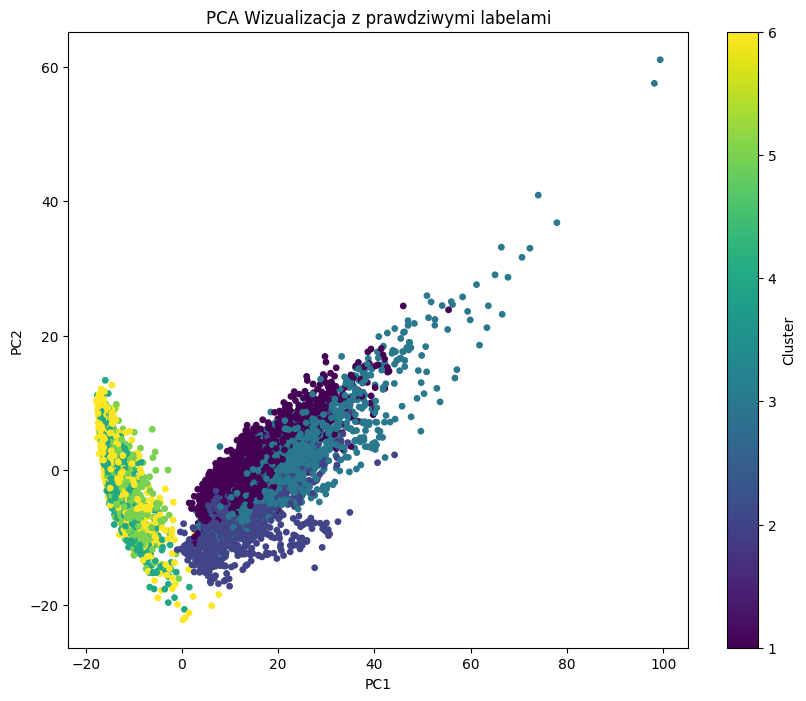

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y, cmap='viridis', s=15)
plt.title("PCA Wizualizacja z prawdziwymi labelami")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

CLUSTERING: K-MEANS

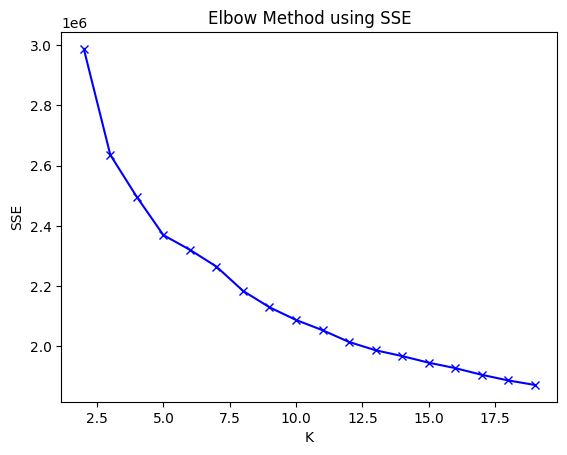

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_pca) for k in range(2, 20)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(range(2, 20), inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method using SSE')
plt.show()

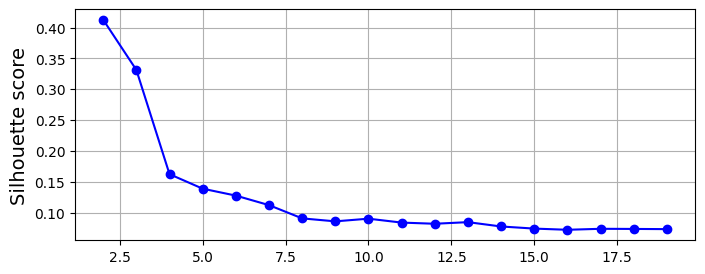

In [14]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k[0:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.ylabel("Silhouette score", fontsize=14)
plt.grid()
plt.show()

Elbow method i silhouette method dają odmienne wyniki - elbow method wydaje dawać najlepszy wynik ok. 5 klastrom, a silhouette 2. Może to oznaczać (i w tym wypadku bardzo prawdopodobnie oznacza), że klastry są do siebie podobne i nie mają wyraźnych rozdziałów. Ma to sens! Ponieważ nasze czynności to marsz, wchodzenie w górę po schodach, schodzenie w dół ze schodów, siedzenie, stanie i leżenie, te czynności naturalnie rozdzielają się na aktywności aktywne i statyczne - można by więc rozważyć podział na dwa klastry, jak sugeruje silhouette. Mnie natomiast ciekawi bardziej, jak clustering methods poradzą sobie z podziałem na 6 klastrów, czyli takich, jaki jest w rzeczywistości.

In [15]:
clf = KMeans(n_clusters=6, random_state=42)
y_pred = clf.fit_predict(X_pca)

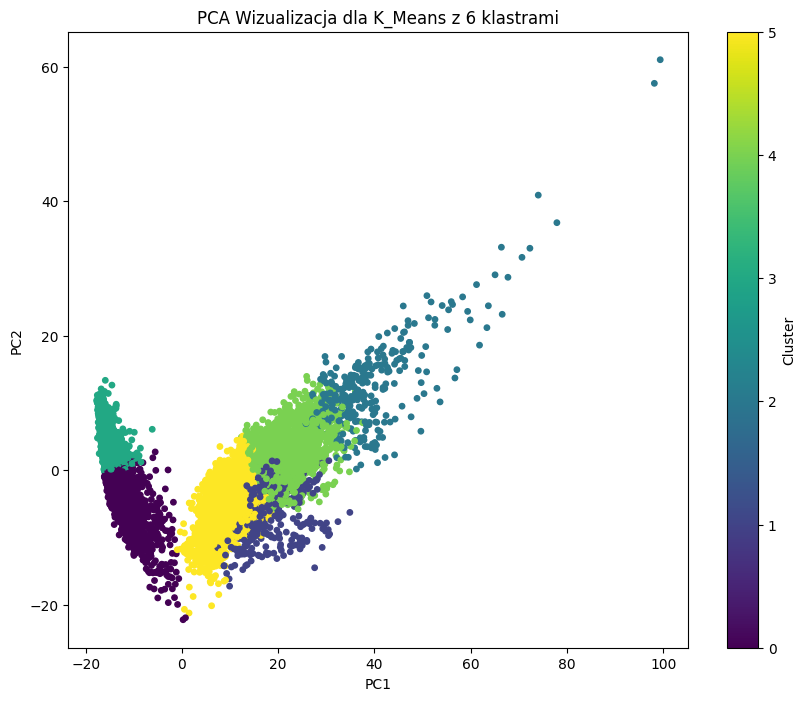

In [16]:
plt.figure(figsize=(10, 8))
plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y_pred, cmap='viridis', s=15)
plt.title("PCA Wizualizacja dla K_Means z 6 klastrami")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

Widzimy, że nasz algorytm lepiej poradził sobie z clusteringiem aktywności aktywnych, mimo że podzielił te dane na cztery kategorie, a nie na trzy. Zamiast tego, aktywności statyczne, które są w rzeczywistości bardzo zmieszane, zostały podzielone na dwie grupy. Ogółem, KMeans wprowadziło pewne uporządkowanie w danych, lecz ten podział wybiega od rzeczywistej sytuacji.

DBSCAN

In [17]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=15, min_samples=10)
y_pred = dbscan.fit_predict(X_pca)

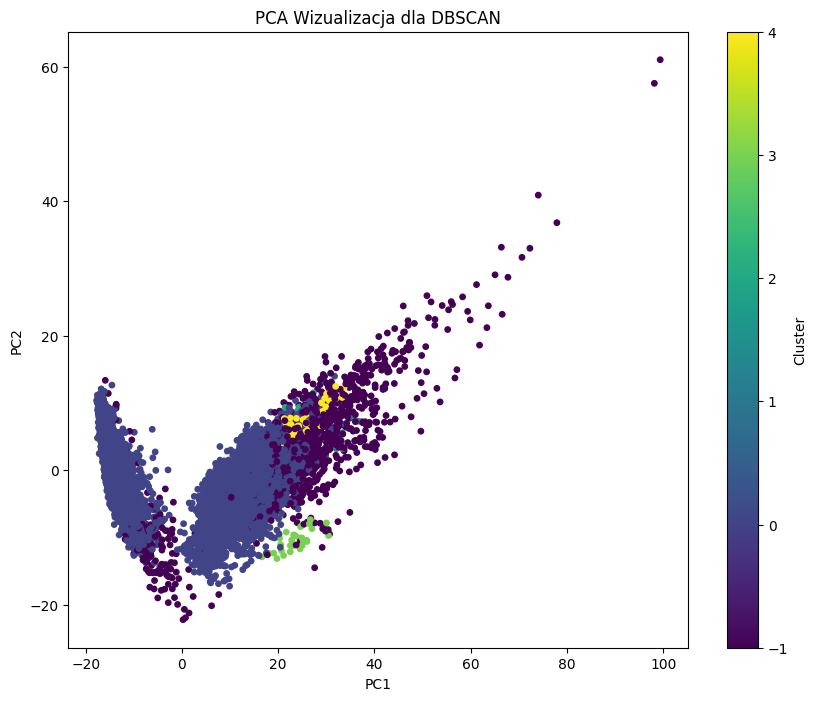

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y_pred, cmap='viridis', s=15)
plt.title("PCA Wizualizacja dla DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

Podział wykonany przez DBSCAN wydaje się niepasujący do rzeczywistego obrazu sytuacji. Próbowałam różnych wartości parametrów, bliskie obecnych wydawały się działać najlepiej. 

Gaussian Mixture Models (GNN)

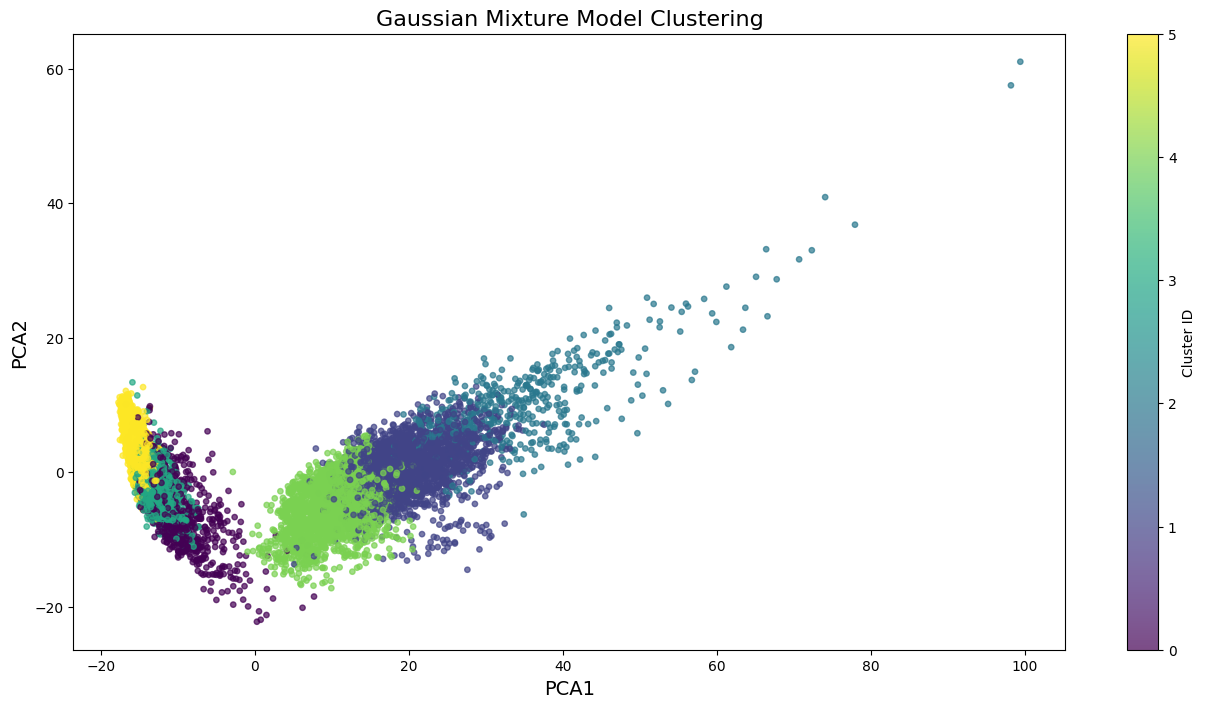

In [19]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=6, n_init=10, random_state=42)
gm.fit(X_pca) 

predicted_labels = gm.predict(X_pca)

X_pca_1_2 = X_pca.iloc[:, :2]

plt.figure(figsize=(16, 8))
plt.scatter(X_pca_1_2.iloc[:, 0], X_pca_1_2.iloc[:, 1], c=predicted_labels, cmap='viridis', s=15, alpha=0.7)
plt.title("Gaussian Mixture Model Clustering", fontsize=16)
plt.xlabel("PCA1", fontsize=14)
plt.ylabel("PCA2", fontsize=14)
plt.colorbar(label="Cluster ID")
plt.show()

Podział dokonany przez GNN wydaje się bliższy rzeczywistości niż KMeans - aktywności statyczne rzeczywiście zostały podzielone na trzy grupy, a aktywne również. Mimo to, kształt klastrów jest inny niż w rzeczywistości. Wydaje mi się, że dane ogólnie są trudne do podziału w klastry. Gdybyśmy ustawili dwa klastry, myślę, że algorytmy poradziłyby sobie znacznie lepiej z podziałem danych na aktywności statyczne/aktywne.

KMEANS JAKO PREPROCESSING

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

kmeans_param_grid = {'kmeans__n_clusters': [10, 20, 30, 40, 50]}
log_reg_param_grid = {'log_reg__C': [0.01, 0.1, 1, 10], 'log_reg__max_iter': [5000, 10000]}
knn_param_grid = {'knn__n_neighbors': [3, 5, 7, 9]}

pipeline_log = Pipeline([
        ("kmeans", KMeans(random_state=2)),
        ("log_reg", LogisticRegression(multi_class="ovr", random_state=2))])
    
pipeline_knn = Pipeline([
        ("kmeans", KMeans(random_state=2)),
        ("knn", KNeighborsClassifier())])

grid_log = GridSearchCV(pipeline_log, param_grid={**kmeans_param_grid, **log_reg_param_grid}, cv=3)
grid_log.fit(X_train, y_train)
print("Best parameters for Logistic Regression pipeline:", grid_log.best_params_)
print("Pipeline Logistic Regression best score:", grid_log.score(X_test, y_test))

grid_knn = GridSearchCV(pipeline_knn, param_grid={**kmeans_param_grid, **knn_param_grid}, cv=3)
grid_knn.fit(X_train, y_train)
print("Best parameters for KNN pipeline:", grid_knn.best_params_)
print("Pipeline KNN best score:", grid_knn.score(X_test, y_test))

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\user\AppData\

Best parameters for Logistic Regression pipeline: {'kmeans__n_clusters': 50, 'log_reg__C': 10, 'log_reg__max_iter': 10000}
Pipeline Logistic Regression best score: 0.9456046624575036
Best parameters for KNN pipeline: {'kmeans__n_clusters': 50, 'knn__n_neighbors': 9}
Pipeline KNN best score: 0.8640116561437591


W ramach sprawdzenia wyników bez użycia KMeans jako preprocessingu, postanowiłam też po prostu przeprowadzić Logistic Regression i KNN.

In [22]:
log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)
log_reg.fit(X_train, y_train)
print("Bez KMeans, Logistic Regression:", log_reg.score(X_test, y_test))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("Bez KMeans, KNN:", knn.score(X_test, y_test))

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Bez KMeans, Logistic Regression: 0.9834871296745993
Bez KMeans, KNN: 0.9601748421563866


Wyniki są lepsze bez preprocessingu! Możliwe, że użycie KMeans jako preprocessingu wprowadza do danych błąd, i lepsze jest użycie zwykłych metod klasyfikacji. Może mieć to następujące wytłumaczenie: KMeans na siłę rozdziela na klastry dane, które w rzeczywistości są dosyć podobne, np. dane aktywności statycznych, i przez to wprowadza nasze klasyfikatory w błąd.

Czym różni się KMeans, K-fold i K Nearest Neighbors?

KMeans to algorytm unsupervised learning, który grupuje dane w określoną liczbę "klastrów", czyli grup danych najbardziej podobnych do siebie. Te klastry są znajdowane poprzez wybranie losowych punktów jako centroid klastrów, by później z każdą iteracją updatować nasze centroidy i ich klastry (zbiory punktów najbliższych temu centroidowi). Każna iteracja wyznacza centrum klastru jako nowy centroid.

KFold to metoda walidacji krzyżowej polegająca na podziale danych na k równych części i k iteracji, podczas któych po kolei każdy z pojedynczych części traktujemy jako zbiór walidacyjny. Ta metoda pozwala nam na wykorzystanie pełni danych do trenowania.

KNN to algorytm supervised learning. W klasyfikacji, KNN przypisuje punkt danych testowych do klasy, do której należy większość jego k najbliższych sąsiadów w danych treningowych. W regresji, KNN przypisuje punktowi średnią wartość k najbliższych sąsiadów.